In [1]:
import sys
from pathlib import Path

# Notebook ka folder
NOTEBOOK_DIR = Path().resolve()

# Project root = parent folder
PROJECT_ROOT = NOTEBOOK_DIR.parent

# Add project root to import path
sys.path.append(str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)


Project root: D:\Langchain_LangGraph_03-12-2025\MyProject


In [2]:
#now importing all the Module which is used to build the AI Model.
from langchain_core.prompts import PromptTemplate,ChatPromptTemplate
from exception import CustomException
from logger_config import logger
import os,sys

#using openai chat model and embedding models
from langchain_openai import ChatOpenAI,OpenAIEmbeddings

#using groq chat model 
from langchain_groq import ChatGroq

#using open source chat model from hugging Face
from langchain_huggingface import ChatHuggingFace,HuggingFaceEmbeddings,HuggingFaceEndpoint

from config import *

from langchain_core.runnables import RunnableBranch,RunnableLambda,RunnableParallel,RunnableSequence,RunnablePassthrough

[2025-12-07 01:20:06,805]-config_variable.py-INFO -Loading the environment Variable
[2025-12-07 01:20:06,809]-config_variable.py-INFO -Environment Variable successfully Loaded


In [3]:
%pwd

'd:\\Langchain_LangGraph_03-12-2025\\MyProject\\notebooks'

In [4]:
#import Langgraph related Modules
import langgraph
from langgraph.graph import StateGraph,START,END
from dataclasses import dataclass
from typing import TypedDict
from typing import Literal,List,Annotated
from langchain_core.messages import AnyMessage,AIMessage,HumanMessage,ToolMessage

from pydantic import BaseModel #using this class we can perform validation to schema

from langgraph.prebuilt import tool_node,tools_condition #in this class we put all tools together
#tools_condition wrt to tool msg it will route the flow data to ttol node to perform execution

from langchain_core.tools import tool,Tool,StructuredTool

from langgraph.graph.message import BaseMessage #this is special class which hold every mesaage init.



## step:1) defining the models components

In [5]:
model1 = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0.2 #we call as creative parameter
)
model1

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001481F1291E0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001481E728A00>, root_client=<openai.OpenAI object at 0x000001481F29BE50>, root_async_client=<openai.AsyncOpenAI object at 0x000001481F78D1B0>, temperature=0.2, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [6]:
model2 = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.2 #we call as creative parameter
)
model2

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000014820852140>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000014820888BE0>, model_name='llama-3.1-8b-instant', temperature=0.2, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
llm = HuggingFaceEndpoint(  
repo_id="meta-llama/Llama-3.1-8B-Instruct",  
task="text-generation",  
max_new_tokens=512,  
do_sample=False,  
repetition_penalty=1.03,  
)  

model3 = ChatHuggingFace(llm=llm, verbose=True)
model3

ChatHuggingFace(llm=HuggingFaceEndpoint(repo_id='meta-llama/Llama-3.1-8B-Instruct', repetition_penalty=1.03, stop_sequences=[], server_kwargs={}, model_kwargs={}, model='meta-llama/Llama-3.1-8B-Instruct', client=<InferenceClient(model='meta-llama/Llama-3.1-8B-Instruct', timeout=120)>, async_client=<InferenceClient(model='meta-llama/Llama-3.1-8B-Instruct', timeout=120)>, task='text-generation'), model_id='meta-llama/Llama-3.1-8B-Instruct', model_kwargs={})

## building different type of complex workflows using LangGraph

### 1) building Iterative workflow

#### defining state or memory schema for this workflow

In [8]:
class TweetGenerateSchema(TypedDict):
    topic : str
    tweet : str | None
    evaluation : Literal['approved','need_improvement'] | None
    feedback : str | None
    iteration : int
    max_iteration : int  #infinite loop ko break karne ke liye we used this.
    

In [9]:
#building graph object.
graph = StateGraph(state_schema=TweetGenerateSchema)
graph

In [10]:
from langchain_core.output_parsers import StrOutputParser
parser = StrOutputParser()

In [11]:
def GenerateTweetNode(state:TweetGenerateSchema)->TweetGenerateSchema:
    #fetching topic from state.
    topic = state['topic']
    
    #dynamic topic converting into structure instruction prompt.
    prompt = PromptTemplate(
        template="""
        You are an expert social media content creator specialized in writing humorous tweets.
        Given the topic below, generate a **short, original, and hilarious tweet**.

        Topic:
        {topic}

        Task Guidelines:
        1. Write a short, engaging tweet related to the topic.
        2. Keep the tweet under **280 characters**.
        3. Use simple, catchy, and funny everyday English.
        4. Add **1–2 relevant hashtags**.
        5. Do NOT use a question–answer format.
        6. Use meme-style logic, punchlines, or highly relatable humor.
        7. Keep the tone light, casual, and entertaining.

        Return ONLY the final tweet text. Do not include explanations or extra commentary.
                
                
        """,
        input_variables=['topic']
    )
    
    #chain forming to execute task.
    chain = prompt | model1 | parser
    
    #invoking chain to execute.
    result = chain.invoke(input={'topic':topic})
    
    return {
        'tweet':result
        }

In [12]:
from pydantic import BaseModel, Field
class EvaluatorSchema(BaseModel):
    evaluation: Literal["approved", "need_improvement"] = Field(
        ...,
        description="Final evaluation status of the tweet",
        examples=["approved", "need_improvement"]
    )
    
    feedback: Annotated[
        str,
        Field(..., description="Provide constructive feedback explaining the strengths and weekness about the tweet after evaluation.")
    ]
    


In [13]:
from langchain_core.output_parsers import PydanticOutputParser
pydan_parser = PydanticOutputParser(pydantic_object=EvaluatorSchema)
pydan_parser

PydanticOutputParser(pydantic_object=<class '__main__.EvaluatorSchema'>)

In [14]:
def TweetEvaluationNode(state:TweetGenerateSchema)->TweetGenerateSchema:
    #fetching the tweet to evaluate by another llm.
    tweet = state['tweet']
    
    #converting them into dynamic instruction prompt
    prompt = PromptTemplate(
        template="""
        
        You are an expert social media content evaluator.

        A tweet has been generated and your task is to evaluate its quality and rule compliance.

        Tweet to evaluate:
        "{tweet}"

        Evaluation Criteria:
        1. Is the tweet under 280 characters?
        2. Is it humorous or entertaining?
        3. Does it use simple, day-to-day English?
        4. Is the tweet original and not generic?
        5. Does it include 1–2 relevant hashtags?
        6. Does it avoid question–answer format?
        7. Is the tweet suitable for public social media use?

        Your task:
        - Evaluate the tweet against the above criteria.
        - Give an overall verdict: **approved** or **need_improvement**.
        - If FAIL, briefly mention what needs improvement.

        Return the response strictly in a structured, concise format.{format_instructions}
        Do not rewrite the tweet or add extra commentary.
        
        """,input_variables=['tweet'],
        partial_variables={'format_instructions':pydan_parser.get_format_instructions()}
    )
    #forming a sequential chain 
    chain = prompt | model2 | pydan_parser
    
    
    #now invoking the chain to execute this task by llm.
    result = chain.invoke(input={'tweet':tweet})
    

    
    return {
        'evaluation':result.evaluation,
        'feedback':result.feedback
    }
        

In [15]:
tweet_text = "Monday mornings hit different ☕ brain says work, soul says bed 😴 #MondayMood #Relatable"
state = TweetGenerateSchema(tweet=tweet_text)
res = TweetEvaluationNode(state=state)
res

[2025-12-07 01:20:08,540]-_client.py-INFO -HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'evaluation': 'approved',
 'feedback': 'The tweet is well-structured, uses humor, and is relatable. It also includes relevant hashtags and is suitable for public social media use. The only minor improvement could be to consider adding more original content, but overall, it meets the criteria.'}

In [16]:
def OptimizeTweetNode(state:TweetGenerateSchema)->TweetGenerateSchema:
    #this will optimize the tweet if not approved my llm
    tweet  = state['tweet']
    feedback = state['feedback']
    evaluation = state['evaluation']
    topic = state['topic']
    
    
     #creating a prompt structure instruction template
    prompt = PromptTemplate(
        template="""
            You are a professional social media strategist.  
            A tweet was generated on the topic: **{topic}**  

            Here is the original tweet:  
            "{tweet}"  

            Evaluation result: **{evaluation}**  
            Evaluator feedback: "{feedback}"  

            Your task:
            - Improve or optimize the tweet while keeping it under 280 characters.  
            - Apply the feedback to make it better (original, punchy, shareable).  
            - Keep the tone engaging and clear.  

            Return the final optimized tweet only in this format:  
            Optimized_Tweet: ...
            """,
                    input_variables=["topic", "tweet", "evaluation", "feedback"],
        )
    
    #passing them to llm model so forming sequnetial chains.
    chain = prompt | model3 | parser
    
    #now invoking chain.
    result = chain.invoke({"topic":topic, "tweet":tweet, "evaluation":evaluation, "feedback":feedback})
    
    #updating them in state memory.
    new_iteration_value = state['iteration'] + 1
    
    return {
        'tweet':result,#result["Optimized_Tweet"]
        'iteration':new_iteration_value,
    }
    

### router function based on condition it will route to nodes

In [17]:
def checkpoint_condition(state:TweetGenerateSchema) :
    #fetching field from state class.
    eval = state['evaluation']
    iter = state['iteration']
    
    if eval == "approved" or iter >= max(state['max_iteration']) :
        return "approved"
    else:
        return 'need_improvement'

In [18]:
#adding the nodes and edges to graph.
graph.add_node(node="GenerateTweetNode",action=GenerateTweetNode)
graph.add_node(node="TweetEvaluationNode",action=TweetEvaluationNode)
graph.add_node(node="OptimizeTweetNode",action=OptimizeTweetNode)
graph.add_edge(start_key=START,end_key="GenerateTweetNode")
graph.add_edge(start_key="GenerateTweetNode",end_key="TweetEvaluationNode")
graph.add_conditional_edges(
    "TweetEvaluationNode",
    checkpoint_condition,
    {
        'approved':END,
        "need_improvement":"OptimizeTweetNode"
    }
)
graph.add_edge(start_key="OptimizeTweetNode",end_key="TweetEvaluationNode")

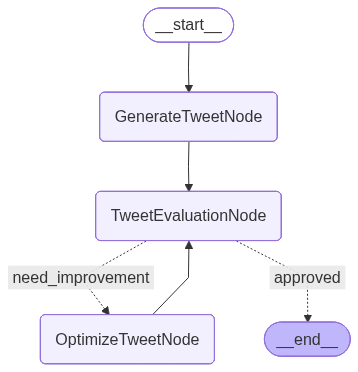

In [19]:
workflow = graph.compile()
workflow

In [20]:
#now passing the initial state to start nodes mei.
initial_state = TweetGenerateSchema(topic="AI impact in Finanace or BFSI Domain",iteration=1,max_iteration=3)
initial_state

{'topic': 'AI impact in Finanace or BFSI Domain',
 'iteration': 1,
 'max_iteration': 3}

In [21]:
#passing this inital state through out workflow and sharing memory to each nodes edges
result = workflow.invoke(initial_state)
result

[2025-12-07 01:20:10,238]-_client.py-INFO -HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[2025-12-07 01:20:10,430]-_client.py-INFO -HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'topic': 'AI impact in Finanace or BFSI Domain',
 'tweet': "AI in finance: When the robots start managing your money, just hope they're better at it than you are! 💸😂 #AIinFinance #MoneyMatters",
 'evaluation': 'approved',
 'feedback': 'The tweet is well-structured, uses simple English, and includes relevant hashtags. It is humorous and entertaining, making it suitable for public social media use.',
 'iteration': 1,
 'max_iteration': 3}